# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Для проведения исследования предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Целевой признак:
- Price — цена (евро)

## Подготовка данных

Импортируем необходимые библиотеки и инструменты для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

Сохраним датасет в переменную df.

In [2]:
df = pd.read_csv('autos.csv')

Рассмотрим первые 5 строк таблицы.

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Также рассмотрим основную информацию о таблице.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видим, что в данных есть пропуски и что столбцы с датами (DateCrawled, DateCreated, LastSeen) имеют некорректный тип данных (object вместо datetime).

Посчитаем количество полных дубликатов.

In [5]:
df.duplicated().sum()

4

Всего 4 полных дубликата, удалим данные строки.

In [6]:
df = df.drop_duplicates()

Также взглянем на корреляцию между числовыми столбцами.

In [7]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
Kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
RegistrationMonth,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


Присутствует слабая обратная линейная зависимость между пробегом и ценой. Остальные данные не коррелируют между собой. Также странные результат получился по столбцу NumberOfPictures, все коэффициенты корреляции равны NaN. Взглянем на значения данного столбца.

In [8]:
df['NumberOfPictures'].unique()

array([0])

Во всех объявлениях указано количество изображений равное 0. Вполне вероятно, что это какая-то ошибка при внесении или сохранении данных. С таким содержимым данный столбец для нас неинформативен и его можно удалить.

Также удалим следующие неинформативные признаки (т.к. от них не зависит стоимость автомобиля):
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Перед удалением столбцов посмотрим последнюю дату создания анкеты и дату скачиваия анкеты из базы.

In [9]:
print(df['DateCrawled'].sort_values(ascending=False).head(1), '\n')
print(df['DateCreated'].sort_values(ascending=False).head(1))

90713    2016-04-07 14:36:58
Name: DateCrawled, dtype: object 

335002    2016-04-07 00:00:00
Name: DateCreated, dtype: object


Перед нами данные до 2016 года. Теперь можно удалить указанные выше столбцы.

In [10]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

Снова посчитаем дубликаты после удаления части столбцов.

In [11]:
df.duplicated().sum()

27539

Теперь количество дубликатов значительно выше. Абсолютно одинаковые строки не понадобятся для обучения, поэтому удалим и их.

In [12]:
df = df.drop_duplicates()

Приведем названия столбцов к змеиному регистру.

In [13]:
df = df.rename(columns={
    'VehicleType': 'Vehicle_Type',
    'RegistrationYear': 'Registration_Year',
    'RegistrationMonth': 'Registration_Month',
    'FuelType': 'Fuel_Type'
})

df.columns = df.columns.str.lower()

In [14]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

Рассмотрим процент пропусков пропусков в каждом столбце.

In [15]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,10.790000
registration_year,0.000000
gearbox,5.380000
power,0.000000
model,5.670000
kilometer,0.000000
registration_month,0.000000
fuel_type,9.520000
brand,0.000000


Пропуски содержатся в 5 столбцах, больше всего пропусков в столбце not_repaired. Во всех слобцах с пропусками их количество больше 5%, поэтому удалять их не стоит.

Приступим к обработке пропусков и аномалий. Сначала рассмотрим столбцы без пропусков, затем - с пропусками.

**1. Цена**  
Рассмотрим диапазон значений в столбце price.

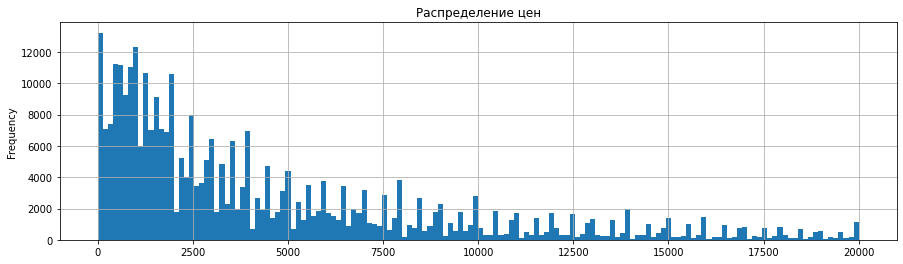

In [16]:
df['price'].plot(kind='hist', bins=150, grid=True, figsize=(15,4), linewidth=2, title='Распределение цен')
plt.show()

Наблюдается большое количество значений в районе нуля. Это явная аномалия, исключим нулевые значения.

In [17]:
df = df.query('price > 0')

**2. Год выпуска**  
Рассмотрим уникальные значения столбца registration_year.

In [18]:
df['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1959, 1956,
       3200, 1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957,
       1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 6500, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934,
       1938, 1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931,
       4500, 1602, 7800, 1947, 1927, 7100, 8200, 1946])

Наблюдается много аномальных значений (до года выпуска первого автомобиля и после настоящего времени). Ограничим выборку с 1900 года по год создания последне анкеты (2016).

In [19]:
df = df.query('1900 <= registration_year <= 2016')

**3. Месяц выпуска**  
Рассмотрим уникальные значения столбца registration_month.

In [20]:
df['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

В данных присутствует "нулевой" месяц. Посмотрим, много ли таких значений и как в целом распределены объявления по месяцу выпуска.

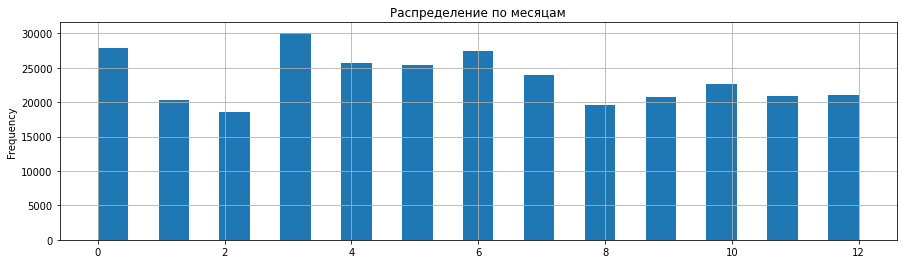

In [21]:
df['registration_month'].plot(kind='hist', bins=25, grid=True, figsize=(15,4), linewidth=2, title='Распределение по месяцам')
plt.show()

Продажи по месяцам распределны достаточно равномерно, в весенние и летние месяцы выпущенных автомобилей больше.

Строк с нулевым месяцем очень много (около 10%). Возможно, таким образом в данных уже заполнены пропущенные значения в данном столбце, либо часть пользователей при заполнении объявлений начинала нумерацию с нуля.

Так как природа нулевых значений не ясна, оставим их без изменений.

**4. Мощность**  
Рассмотрим распределение значений в столбце power.

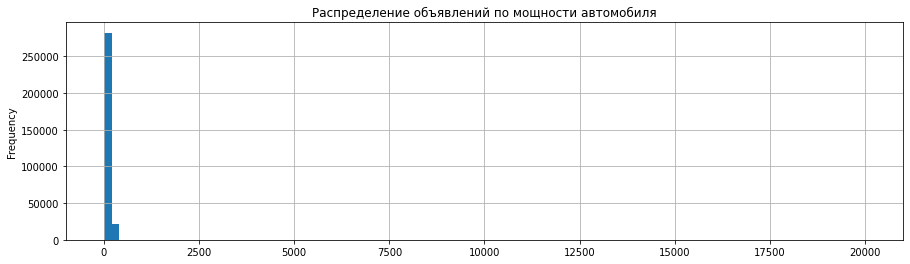

In [22]:
df['power'].plot(kind='hist', bins=100, figsize=(15, 4), grid=True, title='Распределение объявлений по мощности автомобиля')
plt.show()

Все объявления сосредоточены в диапазоне мощности от 0 до примено 500 л.с. Далее идут редкие значения, которые достигают 20 000 л.с. Ограничим наше шкалу до 1000 л.с., чтобы более точно увидеть распределение.

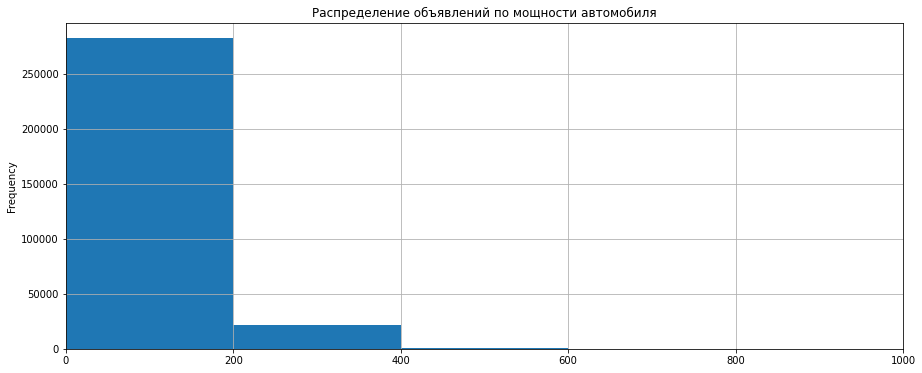

In [23]:
df['power'].plot(kind='hist', bins=100, figsize=(15, 6), grid=True, title='Распределение объявлений по мощности автомобиля')
plt.xlim(0, 1000)
plt.show()

Наблюдается всплеск значений в районе нуля. Объявления с мощностью автомобиля выше 600 л.с. крайне редкие. Ограничим нашу выборку значениями мощности выше нуля и до 600 л.с.

In [24]:
df = df.query('0 < power <= 600')

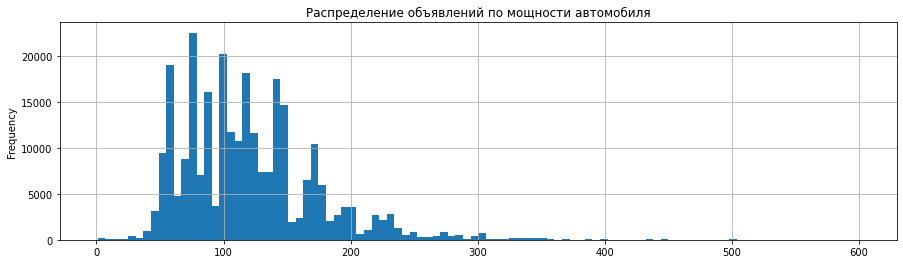

In [25]:
df['power'].plot(kind='hist', bins=100, figsize=(15, 4), grid=True, title='Распределение объявлений по мощности автомобиля')
plt.show()

**5. Пробег**  
Рассмотрим распределение значений в столбце kilometer.

In [26]:
df['kilometer'].value_counts()

150000    181181
125000     29425
100000     11860
90000       9484
80000       8307
70000       7314
60000       6195
50000       5230
40000       4116
30000       3560
20000       3061
5000        2802
10000        878
Name: kilometer, dtype: int64

Значения пробега уже разделены по категориям с шагом в 5000, 10000 или 25000 км в рависимости от разряда числа. Все значения пробега характерны для подержанных автомобилей. Количество объявлений линейно увеличивается по мере роста пробега. Аномалий не выявлено.

**6. Производитель**  
Рассмотрим уникальные значения в столбце brand.

In [27]:
df['brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

Аномалий в столбце brand не выявлено.

Перейдем к обработке столбцов с пропусками.

**7. Тип кузова**  
Рассмотрим уникальные значения в столбце vehicle_type.

In [28]:
df['vehicle_type'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

Так в рамках одной модели автомобиля могут выпускаться разные типы кузова, заполним пропуски значением "unknown".

In [29]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

**8. Коробка передач**  
Рассмотрим уникальные значения в столбце gearbox.

In [30]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Так в рамках одной модели автомобиля могут выпускаться разные типы коробки передач, также заполним пропуски значением "unknown".

In [31]:
df['gearbox'] = df['gearbox'].fillna('unknown')

 **9. Модель автомобиля**  
Рассмотрим уникальные значения в столбце model.

In [32]:
df['model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'astra', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_m

Модель автомобиля невозможно определить по имеющимся данным, поэтому также заполним пропуски значением "unknown".

In [33]:
df['model'] = df['model'].fillna('unknown')

**10. Тип топлива**  
Рассмотрим уникальные значения в столбце fuel_type.

In [34]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Так в рамках одной модели могут выпускаться автомобили с разными типами топлива, также заполним пропуски значением "unknown".

In [35]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')

**11. Факт ремонта**  
Рассмотрим уникальные значения в столбце not_repaired.

In [36]:
df['repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

Факт ремонта также невозможно определить по имеющимся данных, поэтому заполним пропуски на значение "unknown".

In [37]:
df['repaired'] = df['repaired'].fillna('unknown')

Посмотрим на общую информацию о таблице после обработки данных.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273413 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               273413 non-null  int64 
 1   vehicle_type        273413 non-null  object
 2   registration_year   273413 non-null  int64 
 3   gearbox             273413 non-null  object
 4   power               273413 non-null  int64 
 5   model               273413 non-null  object
 6   kilometer           273413 non-null  int64 
 7   registration_month  273413 non-null  int64 
 8   fuel_type           273413 non-null  object
 9   brand               273413 non-null  object
 10  repaired            273413 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.0+ MB


После обработки аномалий объем данных сократился на 20%.
Данные готовы к построению моделей.

## Обучение моделей

### Подготовка данных к построению моделей ###

Рассмотрим 5 моделей:
1. Линейная регрессия
2. Дерево решений
3. Случайный лес
4. Градиентный бустинг CatBoost
5. Градиентный бустинг Light GBM

Для каждой модели необходимо подготовить данные:
- разбить на признаки и целевой признак
- разбить на обучающую, валидационную и тестовую выборки
- масштабировать численные признаки
- закодировать категориальные признаки

Исходя из особенностей моделей для линейной регрессии будем использовать прямое кодирование, для дерева решений и случайного леса - порядковое кодирования, для моделей градиентного бустинга обойдемся без кодирования, т.к. данные модели умеют работать с категориальными признаками.

**Общая подготовка данных**

Разделим данные на признаки и целевой признак.

In [39]:
features = df.drop('price', axis=1)
target = df['price']

Разделим признаки и целевой признак на обучающую, валидационную и тестовую выборки.

In [40]:
features_new, features_test, target_new, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_new, target_new, test_size=0.25, random_state=12345)

Масштабируем численные признаки.

In [41]:
pd.options.mode.chained_assignment = None
numeric = ['registration_year', 'power', 'kilometer', 'registration_month']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Прямое кодирование для линейной регрессии**

Закодируем категориальные признаки и создадим для линейной регрессии заново обучающую, валидационную и тестовую выборки.

In [42]:
features_ohe = pd.get_dummies(features, drop_first=True)

In [43]:
features_new_ohe, features_test_ohe = train_test_split(features_ohe, test_size=0.2, random_state=12345)
features_train_ohe, features_valid_ohe = train_test_split(features_new_ohe, test_size=0.25, random_state=12345)

Масштабируем численные признаки в новых переменных.

In [44]:
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

**Порядковое кодирование для дерева решений и случайного леса**

Создадим кодировщик и обучим его на категориальных признаках тренировочной выборки.  
Преобразуем категориальные признаки на обучающей, валидационной и тестовой выборках.

In [45]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'] # категориальные признаки

In [46]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
encoder.fit(features_train[cat_features])

features_train_oe = features_train.copy()
features_train_oe[cat_features] = encoder.transform(features_train_oe[cat_features])

features_valid_oe = features_valid.copy()
features_valid_oe[cat_features] = encoder.transform(features_valid_oe[cat_features])

features_test_oe = features_test.copy()
features_test_oe[cat_features] = encoder.transform(features_test_oe[cat_features])

Приступим к построению моделей.

### Линейная регрессия ###

Обучим модель линейной регрессии.

In [47]:
%%time

model_lr = LinearRegression(n_jobs=-1)
model_lr.fit(features_train_ohe, target_train)

CPU times: user 11.1 s, sys: 6.68 s, total: 17.7 s
Wall time: 17.7 s


LinearRegression(n_jobs=-1)

Получим предсказания на валидационной выборке.

In [48]:
%%time

predictions_lr = model_lr.predict(features_valid_ohe)

CPU times: user 45.2 ms, sys: 67.5 ms, total: 113 ms
Wall time: 116 ms


Получим значение корня из средней квадратичной ошибки.

In [49]:
rmse_lr = mean_squared_error(target_valid, predictions_lr) ** 0.5
rmse_lr

2602.0875012822567

### Дерево решений ###

Обучим модель дерева решений.

In [50]:
%%time

params_dtr = {'max_depth': range(2, 8)}

model_dtr = DecisionTreeRegressor(random_state=12345)
gscv_dtr = GridSearchCV(model_dtr, params_dtr, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gscv_dtr.fit(features_train_oe, target_train)

CPU times: user 2.34 s, sys: 0 ns, total: 2.34 s
Wall time: 2.35 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1, param_grid={'max_depth': range(2, 8)},
             scoring='neg_mean_squared_error')

Получим предсказания на валидационной выборке.

In [51]:
%%time

predictions_dtr = gscv_dtr.predict(features_valid_oe)

CPU times: user 9.3 ms, sys: 0 ns, total: 9.3 ms
Wall time: 7.77 ms


Получим значение корня из средней квадратичной ошибки.

In [52]:
rmse_dtr = mean_squared_error(target_valid, predictions_dtr) ** 0.5
rmse_dtr

2161.81904021688

Получим значения наилучших гиперпараметров.

In [53]:
gscv_dtr.best_params_

{'max_depth': 7}

### Случайный лес ###

Обучим модель случайного леса.

In [54]:
%%time

params_rfr = {
    'n_estimators': range(10, 51, 10),
    'max_depth': range(2, 7)
}

model_rfr = RandomForestRegressor(random_state=12345)
gscv_rfr = GridSearchCV(model_rfr, params_rfr, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gscv_rfr.fit(features_train_oe, target_train)

CPU times: user 2min 33s, sys: 120 ms, total: 2min 33s
Wall time: 2min 34s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 7),
                         'n_estimators': range(10, 51, 10)},
             scoring='neg_mean_squared_error')

Получим предсказания на валидационной выборке.

In [55]:
%%time

predictions_rfr = gscv_rfr.predict(features_valid_oe)

CPU times: user 116 ms, sys: 7.94 ms, total: 124 ms
Wall time: 134 ms


Получим значение корня из средней квадратичной ошибки.

In [56]:
rmse_rfr = mean_squared_error(target_valid, predictions_rfr) ** 0.5
rmse_rfr

2222.174410437498

Получим значения наилучших гиперпараметров.

In [57]:
gscv_rfr.best_params_

{'max_depth': 6, 'n_estimators': 50}

### Градиентный бустинг CatBoost ###

Обучим модель градиентного бустинга CatBoost.

In [58]:
%%time

model_cb = CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', iterations=100, random_state=12345)
model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 6.19 s, sys: 91.1 ms, total: 6.28 s
Wall time: 6.87 s


Получим предсказания на тестовой выборке.

In [59]:
%%time

predictions_cb = model_cb.predict(features_valid)

CPU times: user 74 ms, sys: 4.27 ms, total: 78.3 ms
Wall time: 75.7 ms


Получим значение корня из средней квадратичной ошибки.

In [60]:
rmse_cb = mean_squared_error(target_valid, predictions_cb) ** 0.5
rmse_cb

1658.8895217205113

### Градиентный бустинг Light GBM ###

Обучим модель градиентного бустинга Light GBM.

Сначала приведем категориальные признаки к категориальному типу данных.

In [61]:
for feature in cat_features:
    features_train[feature] = pd.Series(features_train[feature], dtype='category')
    features_valid[feature] = pd.Series(features_valid[feature], dtype='category')
    features_test[feature] = pd.Series(features_test[feature], dtype='category')

In [62]:
%%time

model_lgbm = LGBMRegressor(metric='rmse', max_depth=7, random_state=12345) # макс.глубина дерева ограничена для увеличения скорости
model_lgbm.fit(features_train, target_train, categorical_feature=cat_features, eval_metric='rmse', verbose=False)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: user 5.35 s, sys: 18.1 ms, total: 5.36 s
Wall time: 5.41 s


LGBMRegressor(max_depth=7, metric='rmse', random_state=12345)

Получим предсказания на валидационной выборке.

In [63]:
%%time

predictions_lgbm = model_lgbm.predict(features_valid)

CPU times: user 611 ms, sys: 0 ns, total: 611 ms
Wall time: 602 ms


Получим значение корня из средней квадратичной ошибки.

In [64]:
rmse_lgbm = mean_squared_error(target_valid, predictions_lgbm) ** 0.5
rmse_lgbm

1604.519639919157

## Анализ моделей

Сравним полученные результаты по всем моделям.

In [65]:
models = ['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'Градиентный бустинг CatBoost', 'Градиентный бустинг Light GBM']
columns = ['Место по скорости обучения', 'Место по скорости предсказания', 'RMSE', 'Место по RMSE', 'RMSE ниже 2500']

results = pd.DataFrame([
    [4, 3, rmse_lr, 5, 'нет'], 
    [1, 1, rmse_dtr, 3, 'да'], 
    [5, 4, rmse_rfr, 4, 'да'], 
    [3, 2, rmse_cb, 2, 'да'], 
    [2, 5, rmse_lgbm, 1, 'да']
], index=models, columns=columns)

results

,Место по скорости обучения,Место по скорости предсказания,RMSE,Место по RMSE,RMSE ниже 2500
Линейная регрессия,4,3,2602.087501,5,нет
Дерево решений,1,1,2161.819040,3,да
Случайный лес,5,4,2222.174410,4,да
Градиентный бустинг CatBoost,3,2,1658.889522,2,да
Градиентный бустинг Light GBM,2,5,1604.519640,1,да


Градиентный бустинг Light GBM дает наименьшее значение RMSE. По скорости обучения он также достаточно быстрый (2 место), но по скорости предсказания он самый медленный.

У градиентного бустинга CatBoost значение RMSE немного выше, как и скорость обучения. При этом по скорости предсказания он заметно обгоняет Light GBM.

Дерево решений - самая быстрая модель по всем признакам, однако значение ошибки у него значительно превышает результаты обоих бустингов.

Линейная регрессия и случайный лес показывают самые низкие результаты по совокупности параметров.

Учитывая, что скорость предсказаний гораздо выше скорости обучения, можно рекомендовать для использования модель градиентного бустинга Light GBM.  
Если же скорость предсказаний является приоритетным критерием, то рекомендовано использовать модель градиентного бустинга CatBoost	(по скорости обучения и значения RMSE она не сильно отстает от Light GBM.

Проверим обе модели на тестовой выборке.

# Тестирование лучшей модели

**CatBoost**

In [66]:
%%time

predictions_cb_test = model_cb.predict(features_test)
rmse_cb_test = mean_squared_error(target_test, predictions_cb_test) ** 0.5
rmse_cb_test

CPU times: user 44.4 ms, sys: 12 µs, total: 44.4 ms
Wall time: 43.6 ms


1643.6633039681888

**Light GBM**

In [67]:
%%time

predictions_lgbm_test = model_lgbm.predict(features_test)
rmse_lgbm_test = mean_squared_error(target_test, predictions_lgbm_test) ** 0.5
rmse_lgbm_test

CPU times: user 608 ms, sys: 0 ns, total: 608 ms
Wall time: 600 ms


1598.663573327216

На тестовой выборке обе модели показали более низкое значение RMSE по сравнению с валидационной выборкой. Полученные данные подтверждают сделанные ранее выводы.